# Section 2
# Technical Report

## Part 1
## Introduction
### Problem Statement

What is the sale value of a house? In capitalist societies there is no exogenous price setter, but rather the price of a house is simply whatever someone is willing to pair for it. This poses a significant challenge for both buyers and sellers in the housing market. House appraisal is a valuable service, and accurate assessment of a house's value provides leverage in negotations, and a competitve advantage for investors. However, accurately evaluating a house's value is difficult undertaking, and so real estate appraisal has historically been an expert domain.

In the last several decades, the rapid expansion of digitization and the consequent arrival of 'Big Data' have open new possibilities for housing appraisal. Machine learning can be a powerful tool in this, but there remains difficultly in calibrating high-accuracy predictive models.

This paper attempts to design an accurate model predicting house price using linear regression, and as a point of reference a K Nearest Neighbour model is also implemented. It is hoped that in designing these models I can gain insight into the optimal model design for predicting the final sale price of houses.

### Data
This report uses the Ames housing dataset. The full dictionary is available here: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

The variable names are preserved throughout this report, although they are reformatted to remove uppercase, and spaces are replaced with underscores for consistency and ease of use. In addition, there is some feature engineering, for example, each house's construction year and sale year are used to compute the home's age at time of sale, and this is used as a continuous variable for training the models. There are also interaction terms added at several points in this report, but in all cases the features are named in a consistent manner, allowing the reader to refer back to the above data dictionary for clarification.

## Part 2
## Exploratory Data Analysis (EDA)

Initial data cleaning was performed, involving the removal or imputation of missing values, as well as some simple feature reformatting; see Section 1. The section that follows takes a first look at our data and I further adjust the data based on my findings. 

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import warnings

# Other settings
%matplotlib inline
pd.options.display.max_rows=100
pd.options.display.max_columns=100
warnings.filterwarnings('ignore')


In [4]:
# Importing dataset with initial cleaning from Section 1:
df = pd.read_csv('../datasets/basic_cleaned_housing_data.csv',sep= '\t')
df.drop(columns= ['Unnamed: 0','id','pid'], inplace=True)
df.head()

,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmtfin_type_1,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,garage_type,garage_area,garage_qual,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,6,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,Attchd,475.0,3,Y,0,44,0,0,0,0,0,3,2010,WD,130500
1,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,6,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,Attchd,559.0,3,Y,0,74,0,0,0,0,0,4,2009,WD,220000
2,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,6,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,Detchd,246.0,3,Y,0,52,0,0,0,0,0,1,2010,WD,109000
3,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,1,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,BuiltIn,400.0,3,Y,100,0,0,0,0,0,0,4,2010,WD,174000
4,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,1,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,Detchd,484.0,3,N,0,59,0,0,0,0,0,3,2010,WD,138500


### Exploring the Target Variable: 'saleprice'

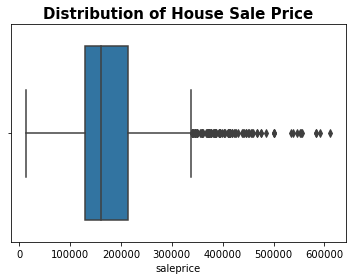

In [5]:
# Investigating target variable
sns.boxplot(df['saleprice'])
plt.title('Distribution of House Sale Price', weight = 'bold', size = 15);

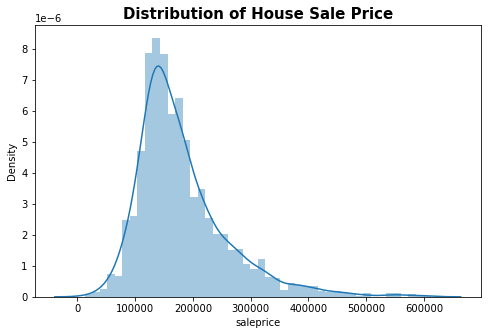

In [6]:
plt.figure(figsize=(8,5))
sns.distplot(df['saleprice'])
plt.title('Distribution of House Sale Price', weight = 'bold', size = 15);

In [7]:
# Our first look at sale price finds a positively skewed distribution.
# There are some issues on either end of the distribution:
# On the positive side there are a fairly large number of outliers, 
# and on the negative side there appear to be values <0 which should be removed:
df.sort_values(by = 'saleprice')

,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmtfin_type_1,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,garage_type,garage_area,garage_qual,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
1608,30,RM,9656,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,2,1923,1970,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,BrkTil,1,678.0,GasA,TA,N,SBrkr,832,0,0,832,0.0,0.0,1,0,2,1,TA,5,Typ,1,Detchd,780.0,2,N,0,0,0,0,0,0,0,6,2010,WD,12789
180,20,A (agr),14584,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Sal,0,Attchd,487.0,2,N,0,0,0,0,0,0,0,2,2008,WD,13100
1293,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,3,720.0,GasA,TA,N,FuseA,720,0,0,720,0.0,0.0,1,0,2,1,TA,4,Typ,0,none,0.0,0,N,0,523,115,0,0,0,0,11,2009,WD,34900
1277,30,RL,8088,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,2,3,1922,1955,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,1,498.0,GasA,TA,N,FuseF,498,0,0,498,0.0,0.0,1,0,1,1,TA,3,Typ,0,Detchd,216.0,2,N,0,0,100,0,0,0,0,2,2006,ConLD,35000
1499,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,4,480.0,GasA,TA,N,FuseA,480,0,0,480,1.0,0.0,0,0,1,1,TA,4,Typ,0,Detchd,308.0,3,Y,0,0,0,0,0,0,0,10,2006,WD,35311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,60,RL,16056,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,Stone,208.0,Gd,TA,PConc,6,1992.0,GasA,Ex,Y,SBrkr,1992,876,0,2868,0.0,0.0,3,1,4,1,Ex,11,Typ,1,BuiltIn,716.0,3,Y,214,108,0,0,0,0,0,7,2006,New,556581
1774,60,RL,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,1,1734.0,GasA,Ex,Y,SBrkr,1734,1088,0,2822,0.0,0.0,3,1,4,1,Ex,12,Typ,1,BuiltIn,1020.0,3,Y,52,170,0,0,192,0,0,1,2009,New,582933
1672,60,RL,17242,Pave,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,9,5,1993,1994,Hip,CompShg,MetalSd,MetalSd,BrkFace,738.0,Gd,Gd,PConc,3,1733.0,GasA,Ex,Y,SBrkr,1933,1567,0,3500,1.0,0.0,3,1,4,1,Ex,11,Typ,1,Attchd,959.0,3,Y,870,86,0,0,210,0,0,5,2006,WD,584500
1939,20,RL,51974,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,PosN,Norm,1Fam,1Story,9,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,710.0,Ex,TA,PConc,6,2660.0,GasA,Ex,Y,SBrkr,2338,0,0,2338,1.0,0.0,2,1,4,1,Gd,8,Typ,2,Attchd,1110.0,4,Y,0,135,0,0,322,0,0,6,2007,New,591587


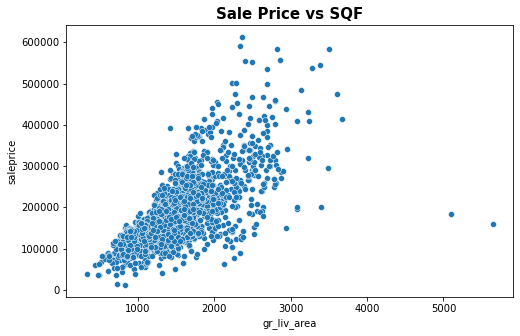

In [8]:
# Sorting saleprice shows that in fact there are no negative values.
# The low prices we see seem appropriate given the small sqf of these units (shown in 'gr_liv_area' feature )
# However, the data dictionary indicates there are other outliers that may become visible when plotting saleprice vs gr_liv_area

plt.figure(figsize=(8,5))
sns.scatterplot(df['gr_liv_area'], df['saleprice'])
plt.title('Sale Price vs SQF', weight = 'bold', size = 15);

In [9]:
# The data dictionary recommends removal of observations where gr_liv_area > 4000 sfq.
# This is done here:
df = df[df['gr_liv_area'] <= 4000]

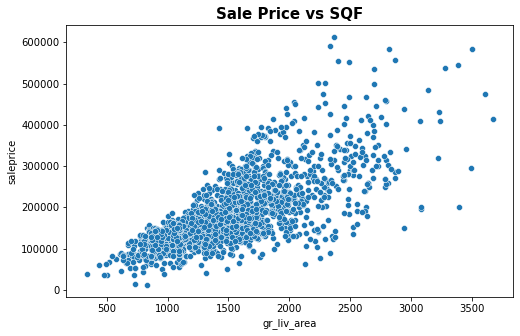

In [10]:
# Reevaluating scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(df['gr_liv_area'], df['saleprice'])
plt.title('Sale Price vs SQF', weight = 'bold', size = 15);

# The outliers are removed although this plot suggests that saleprice is heterskedastic, as variance increases with sqf.

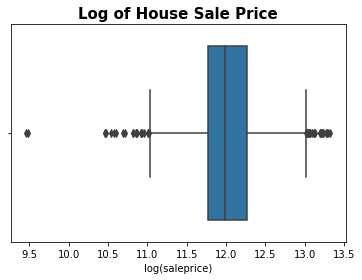

In [11]:
# Evaluating the log of saleprice:
sns.boxplot(np.log(df['saleprice']))
plt.title('Log of House Sale Price', weight = 'bold', size = 15)
plt.xlabel('log(saleprice)');

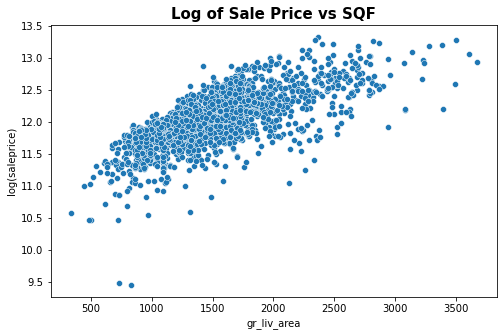

In [12]:
plt.figure(figsize=(8,5))
sns.scatterplot(df['gr_liv_area'], np.log(df['saleprice']))
plt.title('Log of Sale Price vs SQF', weight = 'bold', size = 15)
plt.ylabel('log(saleprice)');

In [13]:
# Our log(saleprice) does seem to reduce heterskedasticity but a couple new outliers pop out.
# These are the two observations with the lowest sale price that we saw above,
# each being less than half the value of the 3rd lowest observed saleprice.
np.log(df['saleprice']).sort_values()

1608     9.456341
180      9.480368
1293    10.460242
1277    10.463103
1499    10.471950
          ...    
148     13.229568
1774    13.275828
1672    13.278512
1939    13.290564
1651    13.323927
Name: saleprice, Length: 2024, dtype: float64

In [14]:
# These two outliers are removed:
df = df[np.log(df['saleprice']) > 10]

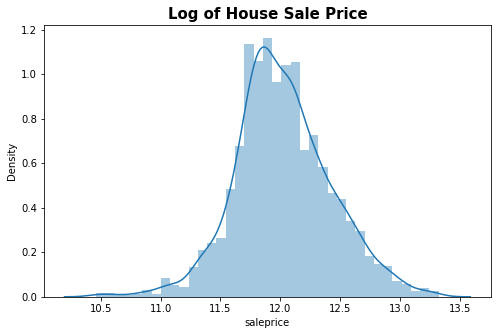

In [15]:
# Reassessing distribution:
plt.figure(figsize=(8,5))
sns.distplot(np.log(df['saleprice']))
plt.title('Log of House Sale Price', weight = 'bold', size = 15);

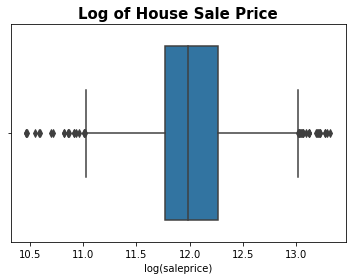

In [16]:
sns.boxplot(np.log(df['saleprice']))
plt.title('Log of House Sale Price', weight = 'bold', size = 15)
plt.xlabel('log(saleprice)');

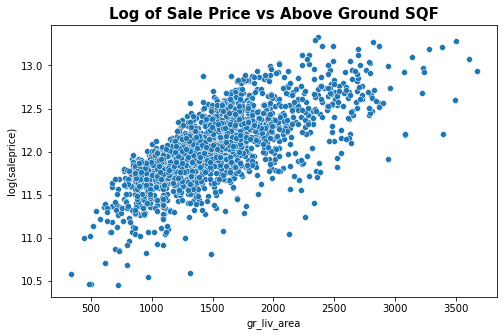

In [17]:
plt.figure(figsize=(8,5))
sns.scatterplot(df['gr_liv_area'], np.log(df['saleprice']))
plt.title('Log of Sale Price vs Above Ground SQF', weight = 'bold', size = 15)
plt.ylabel('log(saleprice)');

Exploration of the target feature suggests the log of saleprice may perform better because it reduces heteroskedasticty and reels in some of the outliers. That said, there is still a fair amount of variance evident when plot log(saleprice) against gr_liv_area. As a result of these findings, in Part 3 I will prepare different models using both y and and log(y) at compare each model's performance metrics.

### Feature Exploration

Determining which features to use when predicting saleprice is challenging because of the large number of categorical and ordinal features that don't lend themselves to correlation analysis. In this section I will treat numeric and non-numeric variables separately. The decision regarding which numeric variables to use will be largely driven by correlation analysis. Once identified, high-correlation variables will be supplmented by selected non-numeric variables, which will be hand-chosen based on general domain knowledge. This process may iterate as model performance metrics are evaluated, and we will also preserve a much larger number of features when regularization is employed, thus automating feature selection.

In [18]:
# Here I define a dataframe for numeric and non-numeric features.
# Technically there are ordinal features that should be considered non-numeric but I still want to see if there is any correlation
# associated with the ordinal values.
# However, ms_subclass is a code refering to different building types, and should be treated as non-numeric.
df_numeric = df.select_dtypes(include= np.number).drop(columns='ms_subclass')
df_numeric.head()

,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_type_1,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_area,garage_qual,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
0,13517,6,8,1976,2005,289.0,6,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,475.0,3,0,44,0,0,0,0,0,3,2010,130500
1,11492,7,5,1996,1997,132.0,6,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,559.0,3,0,74,0,0,0,0,0,4,2009,220000
2,7922,5,7,1953,2007,0.0,6,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,246.0,3,0,52,0,0,0,0,0,1,2010,109000
3,9802,5,5,2006,2007,0.0,1,384.0,744,700,0,1444,0.0,0.0,2,1,3,1,7,0,400.0,3,100,0,0,0,0,0,0,4,2010,174000
4,14235,6,8,1900,1993,0.0,1,676.0,831,614,0,1445,0.0,0.0,2,0,3,1,6,0,484.0,3,0,59,0,0,0,0,0,3,2010,138500


In [19]:
df_non_numeric = df.select_dtypes(exclude= np.number)
df_non_numeric['ms_subclass'] = df['ms_subclass']
df_non_numeric.head()

,ms_zoning,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,exter_qual,exter_cond,foundation,heating,heating_qc,central_air,electrical,kitchen_qual,functional,garage_type,paved_drive,sale_type,ms_subclass
0,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,Gable,CompShg,HdBoard,Plywood,BrkFace,Gd,TA,CBlock,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,Y,WD,60
1,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,Y,WD,60
2,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,Gd,CBlock,GasA,TA,Y,SBrkr,Gd,Typ,Detchd,Y,WD,20
3,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,GasA,Gd,Y,SBrkr,TA,Typ,BuiltIn,Y,WD,60
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Plywood,None,TA,TA,PConc,GasA,TA,Y,SBrkr,TA,Typ,Detchd,N,WD,50


In [20]:
# Here we begin a correlation analysis with numeric features. 
# Note, however, that year should not be included as numeric so its correlation coefficients may be uninterpretable.
# Year-features will be converted into buckets and one-hot encoded later.
df_numeric.corr()[['saleprice']].sort_values(by='saleprice', ascending=False)

,saleprice
saleprice,1.000000
overall_qual,0.802481
gr_liv_area,0.721223
total_bsmt_sf,0.667614
garage_area,0.657274
1st_flr_sf,0.654372
year_built,0.571759
year_remod/add,0.549210
full_bath,0.538030
mas_vnr_area,0.520544


In [21]:
# We can see that there are no features with a strong negative correlation with price 
# so we will only consider positive correlations.
# We will look more closely at features whose Pearson correlation with saleprice is > 0.25
df_numeric.corr()[['saleprice']].sort_values(by='saleprice',ascending=False)

,saleprice
saleprice,1.000000
overall_qual,0.802481
gr_liv_area,0.721223
total_bsmt_sf,0.667614
garage_area,0.657274
1st_flr_sf,0.654372
year_built,0.571759
year_remod/add,0.549210
full_bath,0.538030
mas_vnr_area,0.520544


In [22]:
# Here I create a list of features in df_numeric that have > 25% correlation with saleprice.

corr_over_25_perc = []

for column in df_numeric.columns:
    if stats.pearsonr(df_numeric['saleprice'], df_numeric[column])[0] > 0.25:
        corr_over_25_perc.append(column)

# Defintion of new dataframe looking only at highly correlated numeric features
df_numeric_high_cor = df_numeric[corr_over_25_perc]

<AxesSubplot:>

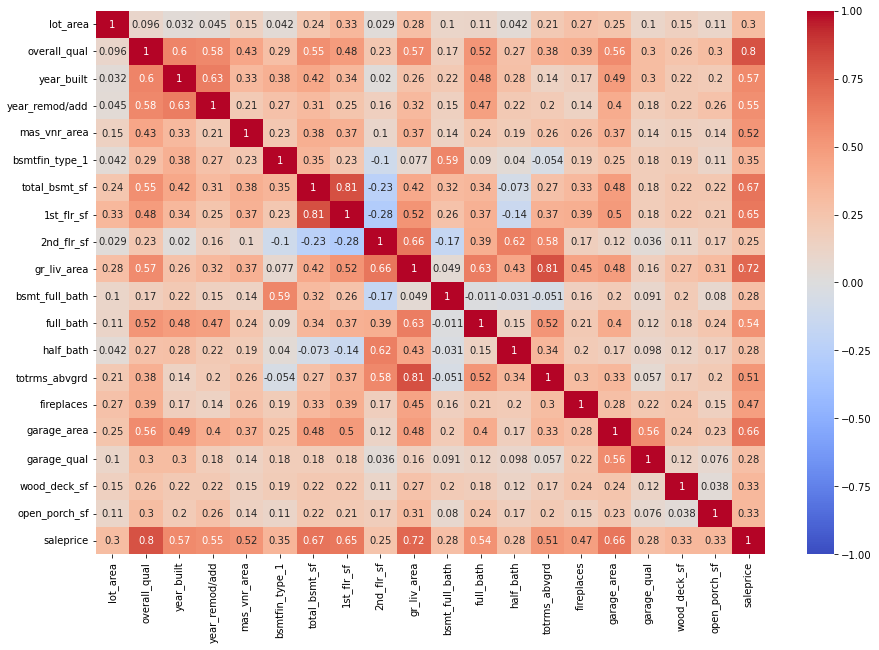

In [23]:
# This code produces a correlation heatmap that can help identify collinearity between our numeric features.
plt.figure(figsize=(15,10))
sns.heatmap(df_numeric_high_cor.corr(), annot=True, cmap = 'coolwarm', vmin = -1)

In [24]:
df_numeric_high_cor.dtypes

lot_area            int64
overall_qual        int64
year_built          int64
year_remod/add      int64
mas_vnr_area      float64
bsmtfin_type_1      int64
total_bsmt_sf     float64
1st_flr_sf          int64
2nd_flr_sf          int64
gr_liv_area         int64
bsmt_full_bath    float64
full_bath           int64
half_bath           int64
totrms_abvgrd       int64
fireplaces          int64
garage_area       float64
garage_qual         int64
wood_deck_sf        int64
open_porch_sf       int64
saleprice           int64
dtype: object

In [25]:
# The heatmap shows that collinearity between numeric features is not a major issue in this dataset.
# There are only two instances where pearson_r > 0.8 for exaplanatory varaibles:
# For stats.pearson_r(1st_flr_sf, total_bsmt_sf) and for stats.pearson_r(totrms_abvgrd, gr_liv_area)
# Here, I remove total_bsmt_sf and totrms_abvgrd, and as well I remove oridnal and year variables, as these one-hot encoded below
df_numeric_model = df_numeric_high_cor.drop(columns=['bsmtfin_type_1','garage_qual', 'overall_qual'])

In [26]:
# Finally, I convert year_built and year_remod/add to 'age' and years since last renovation, called 'years_reno':
df_numeric_model['age'] = df['yr_sold'] - df['year_built']
df_numeric_model['years_reno'] = df['yr_sold'] - df['year_remod/add']

# And I drop the original year variables:
df_numeric_model.drop(columns= ['year_built', 'year_remod/add'], inplace=True)

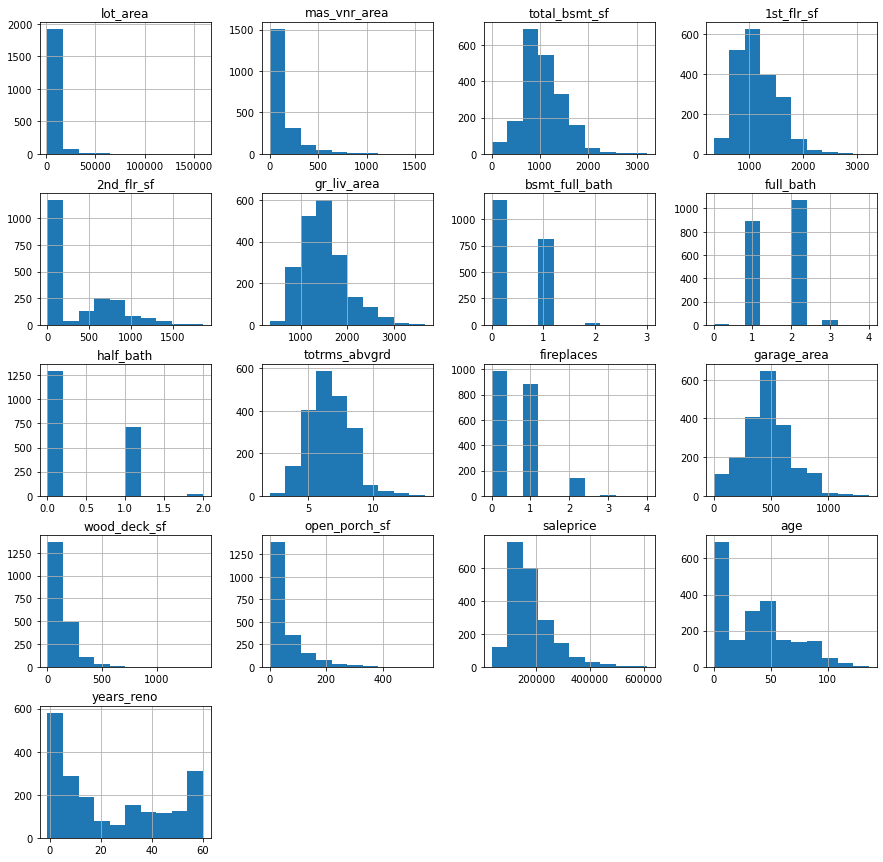

In [27]:
df_numeric_model.hist(figsize=(15,15));

In [28]:
# In the following cells I perform some intial processing of the non-numerical features.
# These variables will eventually need to be one-hot encoded, but this will be done separately for each model
# as it is unlikely they will all be used and the large number of attributes will become cumbersome.

# First, I add in ordinal variables that were removed from df_numeric_model above:

df_non_numeric[['bsmtfin_type_1','garage_qual','overall_qual']] = df_numeric[['bsmtfin_type_1','garage_qual', 'overall_qual']].astype('str')

In [29]:
df_non_numeric['house_style'].unique()

array(['2Story', '1Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin',
       '1.5Unf'], dtype=object)

At this stage it is practical to reduce the number of non-numeric features. Many of the existing non-numeric features may convey similar types of information as it pertains to saleprice. For example, the feature 'neighborhood' is likely to influence saleprice because different areas of the city will vary in desirability (i.e. demand for residential land) and in the amount of residential land available (supply of residential land). Lower density areas will tend to have more land supply which will push prices down. But these areas will also tend to be less urbanized, and this will be reflected in other features such as 'utilities' (i.e., rural areas are less likely to have plumbing) and 'street' (i.e., rural areas are more likely to have unpaved roads. Thus, we can assume that many of the features in our non-numeric dataframe that convey information on urbanity or rurality will be encompassed by the broader geographic attribute, 'neighborhood'.

In [30]:
# Here, we will make some assumptions about which non-numeric features are likely to influence saleprice 
# and redefine a new dataframe for use in our simpler models.
# Features will not be permanently dropped as we will use them again later when using automated feature selection.

df_non_numeric_model = df_non_numeric.drop(columns=[
    'ms_zoning',
    'street',
    'lot_shape',
    'land_contour',
    'neighborhood',
    'land_slope',
    'condition_1',
    'condition_2',
    'house_style',
    'roof_matl',
    'exterior_1st',
    'exterior_2nd',
    'mas_vnr_type',
    'exter_cond',
    'heating',
    'functional',
    'garage_type',
    'sale_type',
    'ms_subclass' 
])

In [31]:
df_non_numeric_model.head()

,utilities,lot_config,bldg_type,roof_style,exter_qual,foundation,heating_qc,central_air,electrical,kitchen_qual,paved_drive,bsmtfin_type_1,garage_qual,overall_qual
0,AllPub,CulDSac,1Fam,Gable,Gd,CBlock,Ex,Y,SBrkr,Gd,Y,6,3,6
1,AllPub,CulDSac,1Fam,Gable,Gd,PConc,Ex,Y,SBrkr,Gd,Y,6,3,7
2,AllPub,Inside,1Fam,Gable,TA,CBlock,TA,Y,SBrkr,Gd,Y,6,3,5
3,AllPub,Inside,1Fam,Gable,TA,PConc,Gd,Y,SBrkr,TA,Y,1,3,5
4,AllPub,Inside,1Fam,Gable,TA,PConc,TA,Y,SBrkr,TA,N,1,3,6


In [32]:
df_non_numeric_model.shape

(2022, 14)

## Part 3
## Preprocessing and Modeling

Part 3 deals with model design, data pre-processing, and model instantiation. It is divided into subsections, each detailing the development of a separate model. The models in each subsection are all designed for the same purpose — predicting the final sale price for a house — but each model developed uses a different approach. In general, there are three broad classes of models presented in this report. First, are basic Linear Regression models, for which features are chosen based on domain knowledge and intuitions developed through the EDA. Second, I explore the use of more advanced regression models that employ regularization and automated feature selection. And the final class of model uses K Nearest Neighbour to predict sale price. 

The subsections are as follows:

1. Basic Multiple Regression - Numeric
2. Log(y) Multiple Regression - Numeric
3. Multiple Regression with Polynomial Features - Numeric
4. Multiple Regression with Selected Interaction Terms - Numeric &  Non-Numeric Features
5. Ridge Regression
6. Lasso Regression
7. K-Nearest Neighbour


### 1. Basic Multiple Regression - Numeric
This first iteration uses only numeric variables and is not expected to have excellent performance. However, using it as a starting point will give a frame of reference for further iterations, and allow us evaluate how other model designs affect results. 

In [33]:
X = df_numeric_model.drop(columns= 'saleprice')
y = df_numeric_model['saleprice']

In [34]:
# Here, I define the training and test groups for the X and y features.
# Note that I use the default test size (0.25) as the sample is large enough that 75% of n is sufficient for model training.
# This also applies to the other models presented below, so I will used a 25:75 test:train split, throughout.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [35]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [36]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)

LinearRegression()

In [37]:
lr.score(X_train_sc, y_train)

0.828744800130101

In [38]:
cross_val_score(lr, X_train_sc, y_train, cv = 10).mean()

0.815913162017661

In [39]:
lr.score(X_test_sc, y_test)

0.8072279970534681

In [40]:
# For reference, here is our baseline prediction, the mean of y.
# This corresponds to an R^2 of 0.
y.mean()

181078.8768545994

We can see that this model is low variance but fairly high bias. The R^2 of 0.83 is a decent result, but we would hope for more accurate predictions in this domain. With that said, 0.83 still vastly outperforms the baseline model, and so this model could still be useable in certain contexts.

### 2. Log(y) Multiple Regression - Numeric
This model uses the same data as the previous one but uses the log of 'saleprice' as the target variable.

In [41]:
X = df_numeric_model.drop(columns= 'saleprice')
y = np.log(df_numeric_model['saleprice'])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [43]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [44]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)

LinearRegression()

In [45]:
lr.score(X_train_sc, y_train)

0.8583166239575363

In [46]:
cross_val_score(lr, X_train_sc, y_train, cv = 10).mean()

0.8487022065150892

In [47]:
lr.score(X_test_sc, y_test)

0.8415878142419833

We can see that the use of log(saleprice) has improved this model's perfomance by a few percentage points. Variance remains low, and overall the bias has been reduced, as R^2 has improved to about 0.86.

### 3. Multiple Regression with Polynomial Features - Numeric
As with the previous two models, this model uses only numeric features, however it increases complexity by adding interaction terms.

In [48]:
# In the next several cells I generate interaction terms and evaluate how they correlate with 'saleprice'.
# Here, I define the PolynomialFeatures method:

poly = PolynomialFeatures(include_bias= False)

In [49]:
df_numeric_model_polynomials = pd.DataFrame(poly.fit_transform(df_numeric_model),columns= poly.get_feature_names(df_numeric_model.columns))

In [50]:
# We can see that some of the interaction terms have a high positive correlation with 'saleprice',
# and some have a moderate negative correlation:

df_numeric_model_polynomials.corr()[['saleprice']].sort_values(by= 'saleprice').T

,age,years_reno,age years_reno,years_reno^2,totrms_abvgrd years_reno,age^2,totrms_abvgrd age,1st_flr_sf age,full_bath years_reno,1st_flr_sf years_reno,full_bath age,total_bsmt_sf age,gr_liv_area years_reno,total_bsmt_sf years_reno,gr_liv_area age,garage_area years_reno,lot_area years_reno,saleprice years_reno,garage_area age,lot_area age,saleprice age,bsmt_full_bath age,bsmt_full_bath years_reno,2nd_flr_sf years_reno,2nd_flr_sf age,half_bath years_reno,open_porch_sf years_reno,wood_deck_sf age,wood_deck_sf years_reno,open_porch_sf age,half_bath age,fireplaces years_reno,mas_vnr_area years_reno,fireplaces age,mas_vnr_area age,lot_area^2,open_porch_sf^2,wood_deck_sf^2,half_bath^2,bsmt_full_bath^2,2nd_flr_sf,2nd_flr_sf bsmt_full_bath,half_bath,2nd_flr_sf open_porch_sf,bsmt_full_bath wood_deck_sf,bsmt_full_bath,bsmt_full_bath half_bath,lot_area,2nd_flr_sf wood_deck_sf,half_bath wood_deck_sf,...,half_bath saleprice,totrms_abvgrd fireplaces,wood_deck_sf saleprice,mas_vnr_area totrms_abvgrd,full_bath fireplaces,mas_vnr_area full_bath,open_porch_sf saleprice,bsmt_full_bath saleprice,1st_flr_sf fireplaces,mas_vnr_area gr_liv_area,full_bath totrms_abvgrd,mas_vnr_area 1st_flr_sf,gr_liv_area fireplaces,mas_vnr_area total_bsmt_sf,mas_vnr_area garage_area,total_bsmt_sf fireplaces,lot_area saleprice,gr_liv_area totrms_abvgrd,fireplaces garage_area,1st_flr_sf,garage_area,garage_area^2,1st_flr_sf^2,total_bsmt_sf,mas_vnr_area saleprice,total_bsmt_sf^2,gr_liv_area full_bath,total_bsmt_sf 1st_flr_sf,gr_liv_area^2,1st_flr_sf totrms_abvgrd,1st_flr_sf full_bath,gr_liv_area,totrms_abvgrd garage_area,total_bsmt_sf full_bath,full_bath garage_area,total_bsmt_sf totrms_abvgrd,fireplaces saleprice,1st_flr_sf garage_area,total_bsmt_sf garage_area,1st_flr_sf gr_liv_area,gr_liv_area garage_area,total_bsmt_sf gr_liv_area,total_bsmt_sf saleprice,full_bath saleprice,garage_area saleprice,1st_flr_sf saleprice,totrms_abvgrd saleprice,gr_liv_area saleprice,saleprice^2,saleprice
saleprice,-0.57161,-0.550308,-0.518057,-0.51224,-0.458456,-0.447584,-0.434685,-0.425058,-0.418898,-0.406615,-0.391071,-0.385063,-0.376006,-0.354674,-0.326746,-0.310535,-0.310487,-0.3017,-0.292715,-0.268651,-0.264759,-0.132856,-0.121672,-0.116752,-0.102194,-0.063474,-0.060637,-0.054599,-0.049093,-0.048296,-0.039124,-0.026621,-0.000584,0.003866,0.014096,0.117372,0.162261,0.202689,0.234947,0.248422,0.250335,0.27552,0.278004,0.280626,0.284601,0.284628,0.297572,0.304531,0.307112,0.318052,...,0.549892,0.555712,0.561171,0.583927,0.584547,0.585116,0.589605,0.592665,0.5946,0.604738,0.605817,0.606613,0.608111,0.616135,0.623158,0.628587,0.639113,0.653108,0.654172,0.654372,0.657274,0.658668,0.661618,0.667614,0.679772,0.688634,0.697107,0.702857,0.708064,0.711998,0.7171,0.721223,0.741133,0.743372,0.743473,0.750791,0.751285,0.774356,0.784879,0.785403,0.809378,0.823677,0.91375,0.914846,0.922771,0.924975,0.92997,0.940033,0.961097,1.0


In [51]:
# Overall, there are too many features to use in the model so I isolate those that have a positive correlation with 'saleprice',
# that is greater that 0.6, or a negative correlation lower than -0.4.
high_corr_columns = []

for column in df_numeric_model_polynomials.columns:
    if stats.pearsonr(df_numeric_model_polynomials['saleprice'],
                      df_numeric_model_polynomials[column])[0] > 0.6 or stats.pearsonr(df_numeric_model_polynomials['saleprice'],
                                                                                       df_numeric_model_polynomials[column])[0] < -0.4:
        high_corr_columns.append(column)

# Defintion of new dataframe looking only at highly correlated numeric features
df_numeric_high_corr = df_numeric_model_polynomials[high_corr_columns]

In [106]:
# In the following cells, I fit the model using the new numeric features, which include interaction terms:

X = df_numeric_high_corr[[column for column in df_numeric_high_corr.columns if 'saleprice' not in column]]
y = df_numeric_high_corr['saleprice']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [108]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [109]:
lr.fit(X_train_sc, y_train)

LinearRegression()

In [110]:
lr.score(X_train_sc, y_train)

0.8795496752137097

In [57]:
cross_val_score(lr, X_train_sc, y_train, cv=10).mean()

0.8622579705618115

In [58]:
lr.score(X_test_sc, y_test)

0.853033836665189

The inclusion of interaction terms produced an interesting result that is not immediately evident. The reader may have noticed that when X and y were defined for this model, I did not use log(saleprice). In this model's first version, log(saleprice) was used and did not improve the model's accuracy. The test score and cross validation score's were almost idential to those in model #2, but the training score was slightly higher, suggesting an increase in variance (i.e., slight model overfit). In the second pass I used a non-transformed 'saleprice' as the target variable and bias reduced by several percentage points, with variance remaining low.

### 4. Multiple Regression with Selected Interaction Terms - Numeric &  Non-Numeric Features
This model retains 3 interactions terms from model #3, which not only had particularly high correlation with 'saleprice'. In addition, selected non-numeric features are one-hot encoded and used to train this model. The selection of features was based on intuition and some degree of trial and error, as many different combinations were tried. The model presented here seemed to be the best performing in terms of minimizing both bias and variance.

In [59]:
# The dataframes containing the numeric and non-numeric features are combined here.
# Hand-selected non-numeric features are used, and dummified during the merge:

df_allType_model = pd.merge(
    df_numeric_model,
    pd.get_dummies(df_non_numeric_model[['overall_qual', 'bldg_type','bsmtfin_type_1','paved_drive', 'kitchen_qual', 'exter_qual','garage_qual']], drop_first= True),
    right_index= True,
    left_index= True
)

In [60]:
# High correlation interaction terms are recreated:
df_allType_model['gr_liv_area*total_basement_sf'] = df_allType_model['gr_liv_area'] * df_allType_model['total_bsmt_sf']
df_allType_model['age*years_reno'] = df_allType_model['gr_liv_area'] * df_allType_model['total_bsmt_sf']
df_allType_model['gr_liv_area**2'] = df_allType_model['gr_liv_area'] ** 2

In [121]:
# In the follow cells the model is fit and scores are produced.

X = df_allType_model.drop(columns= 'saleprice')
y = df_numeric_model['saleprice']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 123)

In [118]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [119]:
lr.fit(X_train_sc, y_train)

LinearRegression()

In [120]:
lr.score(X_train_sc, y_train)

0.9141279445342566

In [66]:
cross_val_score(lr, X_train_sc, y_train, cv = 5).mean()

0.900754675465446

In [67]:
lr.score(X_test_sc, y_test)

0.9053042213118109

This model ended up being the best performing and was used to test the Kaggle data. It had a nice R^2 of 0.91, with low variance. Here, as with model #3, I tried using both 'saleprice' and log(saleprice) as target features, and again the model performed better with non-transformed 'saleprice'.

#### Kaggle Output
As the best performing model, the Kaggle test data set is fit, formatted, and exported in the following cells:

In [68]:
kaggle_train = pd.read_csv('../datasets/kaggle_train.tsv', sep= '\t')

In [69]:
kaggle_train.set_index('Unnamed: 0', inplace= True)

In [70]:
kaggle_train_sc = ss.transform(kaggle_train.drop(columns='id'))

In [71]:
pred = lr.predict(kaggle_train_sc)

In [72]:
kaggle_submission = pd.DataFrame(pred)

In [73]:
kaggle_submission.rename(columns={0:'SalePrice'}, inplace=True)

In [74]:
kaggle_submission['Id'] = kaggle_train['id']
kaggle_submission = kaggle_submission[['Id','SalePrice']]

In [75]:
kaggle_submission = kaggle_submission.sort_values(by='Id')

In [76]:
kaggle_submission.to_csv('../datasets/kaggle_submission_6.csv', index=False)

### 5. Ridge Regression

For the following two models I attmpt to automate feature selection through regularization. This is done using ridge and lasso regression models. I use the same dataset as above, 'df_allType_model', which contains a mix of numeric and non-numeric variables, including several interation terms that were found to be highly correlated with 'saleprice'.

In [77]:
X = df_allType_model.drop(columns= 'saleprice')
y = df_numeric_model['saleprice']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 123)

In [79]:
ss = StandardScaler()

In [80]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [81]:
# First, instantiation of the ridge regression.
# I use RidgeCV to find the optimal alpha

r_alphas = np.logspace(-20,-10,300)
ridge_model = RidgeCV(alphas= r_alphas, scoring='r2', cv = 5)
ridge_model = ridge_model.fit(X_train_sc, y_train)

In [82]:
# The optimal value for alpha is:
ridge_model.alpha_

1.4696843861124473e-20

In [83]:
ridge_model.score(X_train_sc, y_train)

0.914127944534251

In [84]:
cross_val_score(ridge_model, X_train_sc, y_train, cv = 5).mean()

0.9007546754653942

In [85]:
ridge_model.score(X_test_sc, y_test)

0.9053042213120023

### 6. Lasso Regression

In [86]:
# Second, I fit the lasso regression.
# Again, I find the optimal alpha, here using LassoCV:

l_alphas = np.logspace(-10,1,100)
lasso_model = LassoCV(alphas= l_alphas, cv = 5)
lasso_model = lasso_model.fit(X_train_sc, y_train)

In [87]:
lasso_model.alpha_

1.6681005372000558e-10

In [88]:
lasso_model.score(X_train_sc, y_train)

0.9141250338236377

In [89]:
cross_val_score(lasso_model, X_train_sc, y_train, cv= 5).mean()

0.900502794513671

In [90]:
lasso_model.score(X_test_sc, y_test)

0.9052901614125627

The regularization models did not perform better than the vanilla model. They were optimized using their respective cross-validation method, with each producing negative values for alpha.

### 7. K-Nearest Neighbour

In this final model I implement a K-Nearest Neighbour Regressor model to attempt to predict 'saleprice'. Hyperparameters are tuned using GridSearchCV to find the optimal values.

In [91]:
knn = KNeighborsRegressor()

In [92]:
# Dictionary of hyperparameters.
knn_params = {
    'n_neighbors': range(1, 51, 2),
    'metric': ['euclidean', 'manhattan']
}

In [93]:
# Here, I find the optimal parameters for the knn model:

knn_gridsearch = GridSearchCV(KNeighborsRegressor(),
                              knn_params,
                              cv = 5,
                              verbose=1)

In [94]:
knn_gridsearch.fit(X_train_sc, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [95]:
knn_gridsearch.best_score_

0.8811977203751422

In [96]:
# The optimal parameters for the knn model:

knn_gridsearch.best_params_

{'metric': 'manhattan', 'n_neighbors': 7}

In [97]:
best_knn = knn_gridsearch.best_estimator_

In [98]:
best_knn.score(X_train_sc, y_train)

0.9140465338391501

In [99]:
cross_val_score(best_knn, X_test_sc, y_test).mean()

0.840720394398917

In [100]:
best_knn.score(X_test_sc, y_test)

0.8742966880644756

The K Nearest Neighbour model performed surprisingly well, although not up to the level of some of the more complex linear regression models the model's accuracy is nevertheless quite high at 0.91, although it is slightly overfit, as the test score is considerably lower at 0.87, and the cross-validation score is even lower, at 0.84.

## Part 4
## Interpretation and Conclusions

The below table provides a summary of model performance:

|Model Number #| Description | Parameters | CV score | Train score | Test score |
| --- | --- | --- | --- | --- | --- |
|1| **`Basic Multiple Regression - Numeric`** |na|0.82|0.83|0.81|
|2| **`Log(y) Multiple Regression - Numeric`** |na|0.85|0.86|0.84|
|3| **`Multiple Regression with Polynomial Features - Numeric`** |na|0.86|0.88|0.85|
|4| **`Multiple Regression with Selected Interaction Terms - Numeric &  Non-Numeric Features`** |na|0.90|0.91|0.91|
|5| **`Ridge Regression`** |α= 1.4696843861124473e-20|0.90|0.91|0.90|
|6| **`Lasso Regression`** |α= 1.6681005372000558e-10|0.90|0.91|0.91|
|7| **`K Nearest Neighbours`** |'manhattan'; k=7|0.84|0.91|0.87|

In terms of bias, the best score I reached was 0.91, which was the same after rounding for each of the latter four models. That said, they do not all perform equally well in terms of variance. This is most notable with the KNN model, for which the cross-val score is considerably lower than the training score. Variance looks very good for each of models 4, 5, and 6, however in the case of the latter two — that is, the regularized models (Ridge and Lasso) — the parameter values are negative, which is non-intuitive and calls the validity of these models into question. For that reason, my conclusion is that model #4 is the best predictor of house price, which includes both numeric and non-numeric features, several interactions terms, and which uses sale price in dollars (i.e., not log('saleprice') as the target feature.

The difference in performance between models using y or log(y) raises some interesting points. The reader may recall from the EDA that there does appear to be some non-linearity in sale price with respect to sqf (variance in saleprice increases as saleprice and sqf get larger), and so this may explain why model #2 performs better than model #1. Using log(y) only hurts model performance after interactions terms are included, which may be because some of the non-linearity is captured by those polynomial features, meaning that taking the log(y) doesn't have the same impact.

Another valuable takeaway comes from the calibration of model #4, through the trial-and-error assessment of different dummified categorical and ordinal features. In the EDA I discussed how the attribute 'neighborhood' would likely capture much of the information on density and urbanity/rurality that other attributes would, and conjectured that 'neighborhood' could serve as a proxy for many other variables that could be excluded. In practice, though, 'neighborhood' tended to hurt model performance, and my final model #4 showed significant improved only after I removed it, and added in several other features that I thought might express urbanity/rurality. In part, this may simply be because there were too many unique neighbourhoods in Ames, and so including a dummy for each may have pushed the model up against its complexity limit (that is, the number of features is constrained by sample size), which meant that too many other important variables had to be excluded in order to make room. Another possibility is simply that neighbourhood isn't, in the end, all that good an indicator of value. This can happen when there is significant diversity within neighbourhoods, and not only between them. In such cases, the fact that a house is sold in some neighbourhood may not tell very much at all about the home, because there are a wide range of income levels within the neighbourhood. In some cases, municipal boundaries can even contain starkly contrasting urban and rural areas. 

While neighbourhood ended up hurting my models in this particular project, it doesn't mean that it will never be useful. Again, the sample size proved a constraint here, as some rejected versions of model 4 had even better performance than my final versions, but used too many features to be able to execute k-fold cross-validation. My recommendation for future study would be to collect a larger dataset, if only to allow for more features to be used in modelling sale price. It remains possible that neighbourhood could serve as a valuable attribute in a regression with perhaps a hundred features or more.